In [1]:
## Standard Stuff
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.pyplot as plt
import dask.array as da
import numcodecs

## HEALPix Specific
import healpix as hp
import easygems.healpix as egh
import easygems.remap as egr

import intake     # For catalogs
import zarr       

In [2]:
from tqdm import tqdm

In [3]:
def get_axis(extent, subplot_kw=None, **kwargs):
    """Create cartopy.GeoAxis limited area with for a given extent."""
    if not subplot_kw:
        subplot_kw = {"projection": ccrs.PlateCarree()}
        
    fig, ax = plt.subplots(subplot_kw=subplot_kw, **kwargs)
    # ax.coastlines()
    ax.set_extent(extent)
    
    return fig, ax

In [4]:
def above_percentile(da, ptile):
    ptile = np.r_[ptile]
    # print(ptile)
    ncells = da['cell'].size
    above_ptile = np.zeros((ncells,ptile.size))
    for ic in tqdm(range(ncells)):
        above_ptile[ic] = np.interp(ptile, da.isel(cell=ic).values, da['pr_vals'].values)
    above_ptile = xr.DataArray(above_ptile, {'cell':np.arange(ncells), 'ptile': ptile})
    above_ptile['crs'] = da['crs']
    return above_ptile

In [5]:
def zoom_out(da):
    da_coarse = da.groupby((da['cell'])//4).mean('cell')
    da_coarse['crs'] = da['crs'].assign_attrs(healpix_nside = da.crs.healpix_nside//2)
    return da_coarse

In [6]:
np.log10(150)

np.float64(2.1760912590556813)

In [7]:
np.r_[0,np.logspace(-1,2.17,24)]

array([0.00000000e+00, 1.00000000e-01, 1.37349185e-01, 1.88647986e-01,
       2.59106472e-01, 3.55880628e-01, 4.88799142e-01, 6.71361638e-01,
       9.22109739e-01, 1.26651021e+00, 1.73954145e+00, 2.38924601e+00,
       3.28160993e+00, 4.50726449e+00, 6.19069104e+00, 8.50286370e+00,
       1.16786140e+01, 1.60404812e+01, 2.20314701e+01, 3.02600447e+01,
       4.15619248e+01, 5.70849650e+01, 7.84057342e+01, 1.07689637e+02,
       1.47910839e+02])

In [8]:
catfn='/home/tmerlis/hackathon/hackathon_cat_may14_main.yaml'

combo_cat = intake.open_catalog(catfn)

# 'coarse' is an online coarse-graining of 8 neighboring grid cells ~25km
# xsh24 = X-SHiELD 2024 model version, unpublished
# xsh21 = X-SHiELD 2021 model version, many articles including Cheng et al. 2022 GRL
print (list(combo_cat)) 

['xsh24_coarse', 'xsh24_native', 'xsh21_coarse', 'scream2D_hrly', 'scream_ne120', 'scream_lnd', 'ifs_fesom', 'icon_3hp003']


In [9]:
# select zoom level and the part of the combined catalog you're interested in
# coarse stores are available at zoom 7 ~50km and lower
zoom_select = 6
ds = combo_cat.xsh24_coarse(zoom=zoom_select).to_dask()
# attach coordinates; otherwise can't use lat and lon and selecting regions or taking a zonal mean won't work
ds = ds.pipe(egh.attach_coords)

# native stores are available at zoom 10 ~6.4km and lower, fewer variables and all are 2d
dsn = combo_cat.xsh24_native(zoom=zoom_select).to_dask()
dsn = dsn.pipe(egh.attach_coords)

zoom_hr = 10
dsn_hr = combo_cat.xsh24_native(zoom=zoom_hr).to_dask()
dsn_hr = dsn_hr.pipe(egh.attach_coords)

# we downloaded output from DOE's SCREAM model to stellar
# conceivably, we could add to our local collection of models during the week
# or augment the catalog with observational datasets
ds_scream = combo_cat.scream_ne120(zoom=zoom_select).to_dask()
ds_scream = ds_scream.pipe(egh.attach_coords)

/home/rv5936/.conda/envs/easy25/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),
/home/rv5936/.conda/envs/easy25/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),
/home/rv5936/.conda/envs/easy25/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping 

In [10]:
to_mmday = 86400

In [11]:
pr_vals = np.linspace(0,170,35) 

In [13]:
pr_vals = np.r_[0,0.1*(2)**np.arange(6),np.linspace(5,100,20),np.linspace(100,200,11)]
year = slice('2020-01-01','2020-12-31')

counts = []
for pr_val in tqdm(pr_vals):
    counts.append((dsn_hr['pr'].sel(time=year) > pr_val/to_mmday).sum('time').compute())

counts = xr.concat(counts, 'pr_vals')
counts['pr_vals'] = pr_vals

100%|██████████| 38/38 [27:47<00:00, 43.88s/it]


In [21]:
counts_max = dsn_hr['time'].sel(time=year).size

In [22]:
percentiles = 1 - counts/counts_max

In [23]:
n_zoom_out = zoom_hr - zoom_select
for i in tqdm(range(n_zoom_out)):
    percentiles = zoom_out(percentiles)

100%|██████████| 4/4 [00:17<00:00,  4.43s/it]


In [24]:
world = [-180, 180, -90, 90]

In [25]:
above_ptile = above_percentile(percentiles, [0.9,0.99,0.999])

100%|██████████| 49152/49152 [00:05<00:00, 9187.92it/s]


In [26]:
lowres_pr99 = dsn['pr'].sel(time=year).quantile(0.99, 'time').compute()*to_mmday

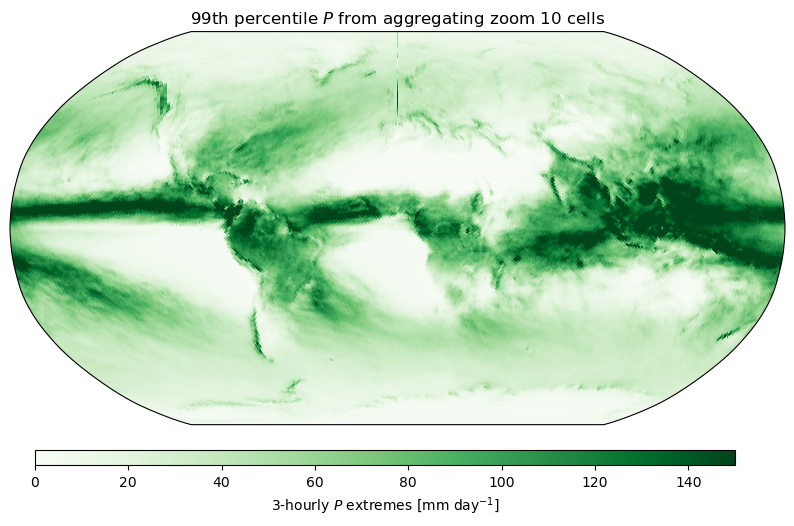

In [35]:
fig, ax = get_axis(world, subplot_kw={'projection': ccrs.Robinson()}, figsize=(10,6))
hps = egh.healpix_show(above_ptile.sel(ptile=0.99), ax=ax, vmin=0, vmax=150, cmap='Greens')

cax = fig.add_axes([0.15,0.1,0.7,0.025])
fig.colorbar(hps, cax=cax, orientation='horizontal', label='3-hourly $P$ extremes [mm day$^{-1}]$')

ax.set_title('$99$th percentile $P$ from aggregating zoom 10 cells')
plt.show()

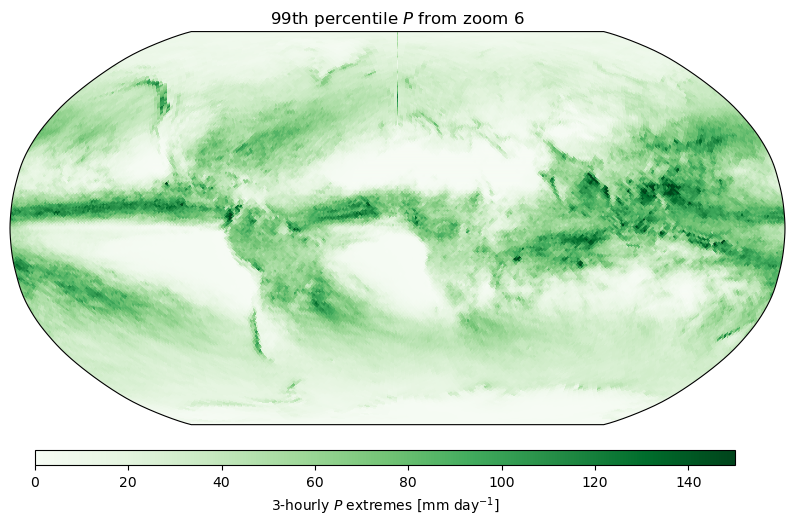

In [36]:
fig, ax = get_axis(world, subplot_kw={'projection': ccrs.Robinson()}, figsize=(10,6))
hps = egh.healpix_show(lowres_pr99, ax=ax, vmin=0, vmax=150, cmap='Greens')

cax = fig.add_axes([0.15,0.1,0.7,0.025])
fig.colorbar(hps, cax=cax, orientation='horizontal', label='3-hourly $P$ extremes [mm day$^{-1}]$')

ax.set_title('$99$th percentile $P$ from zoom 6')
plt.show()

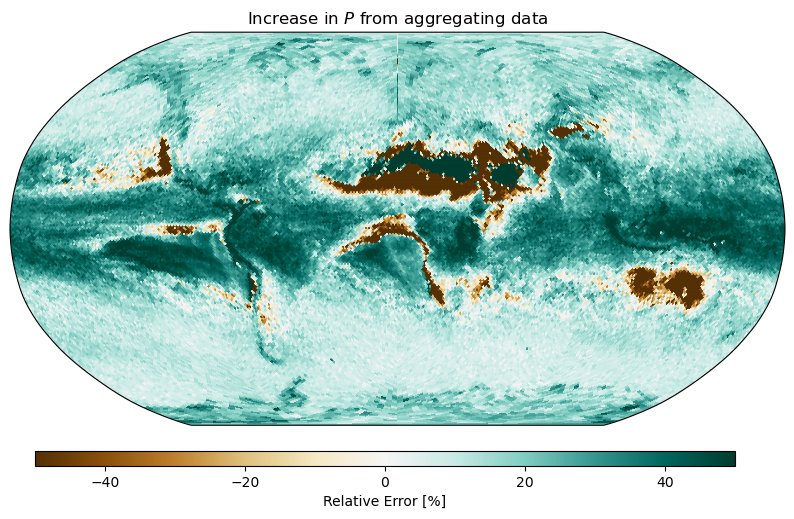

In [33]:
fig, ax = get_axis(world, subplot_kw={'projection': ccrs.Robinson()}, figsize=(10,6))
hps = egh.healpix_show((above_ptile.sel(ptile=0.99) - lowres_pr99)*100/above_ptile.sel(ptile=0.99), ax=ax, vmin=-50, vmax=50, cmap='BrBG')

cax = fig.add_axes([0.15,0.1,0.7,0.025])
fig.colorbar(hps, cax=cax, orientation='horizontal', label='Relative Error [%]')

ax.set_title('Increase in $P$ from aggregating data')
plt.show()

In [ ]:
highres_pr99 = dsn_hr['pr'].sel(time=year).quantile(0.99, 'time').compute()*to_mmday

In [ ]:
highres_pr99['crs'] = dsn_hr['crs']
for i in tqdm(range(n_zoom_out)):
    highres_pr99 = zoom_out(highres_pr99)

In [ ]:
fig, ax = get_axis(world, subplot_kw={'projection': ccrs.Robinson()}, figsize=(10,6))
egh.healpix_show(highres_pr99, ax=ax, vmin=0, vmax=150, cmap='Greens')
plt.show()

In [ ]:
fig, ax = get_axis(world, subplot_kw={'projection': ccrs.Robinson()}, figsize=(10,6))
egh.healpix_show((above_ptile.sel(ptile=0.99) - highres_pr99)*100/above_ptile.sel(ptile=0.99), ax=ax, vmin=-10, vmax=10, cmap='BrBG')
plt.show()

<h4>Multivariate Scaling</h4>